In [ ]:
# -*- coding: utf-8 -*-
"""
FEM TM^z: Dispersión por cilindro PEC con ABC 1er orden.
Figura 2×3 cuadrada rellenando TODO el cuadrado (rejilla cartesiana).
Interior del PEC en blanco. Interpolación correcta de complejos (Re+Im).
"""

# ---------- Backend para VS Code ----------
import matplotlib
try:
    matplotlib.use('QtAgg')    # pip install pyqt5
except Exception:
    try:
        matplotlib.use('TkAgg')  # conda install tk
    except Exception:
        pass

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, LinearTriInterpolator
from matplotlib.patches import Circle
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

# ========================= MALLA =========================
def annulus_mesh(R, a, n_r=32, n_theta=192):
    rs = np.linspace(a, R, n_r)
    the = np.linspace(0.0, 2.0*np.pi, n_theta, endpoint=False)
    rr, tt = np.meshgrid(rs, the, indexing='ij')
    x = (rr*np.cos(tt)).ravel(); y = (rr*np.sin(tt)).ravel()
    pts = np.c_[x, y]

    def nid(i, j): return i*n_theta + j
    tris = []
    for i in range(n_r-1):
        for j in range(n_theta):
            jp = (j+1) % n_theta
            n00 = nid(i, j);     n10 = nid(i+1, j)
            n01 = nid(i, jp);    n11 = nid(i+1, jp)
            tris.append([n00, n10, n11]); tris.append([n00, n11, n01])
    tris = np.array(tris, dtype=int)

    inner_ring = [nid(0, j) for j in range(n_theta)]
    outer_ring = [nid(n_r-1, j) for j in range(n_theta)]
    inner_edges = np.array([[inner_ring[j], inner_ring[(j+1)%n_theta]] for j in range(n_theta)], int)
    outer_edges = np.array([[outer_ring[j], outer_ring[(j+1)%n_theta]] for j in range(n_theta)], int)
    return pts, tris, inner_edges, outer_edges

# ======================= ENSAMBLE ========================
def assemble_K_M(pts, tris):
    N = pts.shape[0]
    K = lil_matrix((N, N), dtype=complex)
    M = lil_matrix((N, N), dtype=complex)
    Mloc = (1.0/12.0) * np.array([[2,1,1],[1,2,1],[1,1,2]], float)
    for tri in tris:
        ids = tri; x = pts[ids,0]; y = pts[ids,1]
        A = np.array([[1,x[0],y[0]],[1,x[1],y[1]],[1,x[2],y[2]]], float)
        area = 0.5*abs(np.linalg.det(A))
        if area <= 1e-20: continue
        invA = np.linalg.inv(A); b = invA[1,:]; c = invA[2,:]
        Ke = area * (np.outer(b,b) + np.outer(c,c))
        Me = area * Mloc
        for i in range(3):
            I = ids[i]
            for j in range(3):
                J = ids[j]
                K[I,J] += Ke[i,j]; M[I,J] += Me[i,j]
    return csr_matrix(K), csr_matrix(M)

def assemble_robin_and_rhs(pts, edges, k0, E0, robin_coeff):
    N = pts.shape[0]
    Arobin = lil_matrix((N,N), dtype=complex)
    b = np.zeros(N, dtype=complex)
    def Einc(x, y): return E0*np.exp(-1j*k0*x)
    for (i,j) in edges:
        xi,yi = pts[i]; xj,yj = pts[j]
        L = np.hypot(xj-xi, yj-yi)
        M1d = (L/6.0)*np.array([[2.0,1.0],[1.0,2.0]], complex)
        xm,ym = 0.5*(xi+xj), 0.5*(yi+yj); r = np.hypot(xm,ym)
        nx,ny = (xm/r, ym/r) if r>0 else (1.0,0.0)
        Ei, Ej = Einc(xi,yi), Einc(xj,yj)
        dEn_i = (-1j*k0)*nx*Ei; dEn_j = (-1j*k0)*nx*Ej
        Arobin[i,i]+=robin_coeff*M1d[0,0]; Arobin[i,j]+=robin_coeff*M1d[0,1]
        Arobin[j,i]+=robin_coeff*M1d[1,0]; Arobin[j,j]+=robin_coeff*M1d[1,1]
        rhs_i = dEn_i + robin_coeff*Ei; rhs_j = dEn_j + robin_coeff*Ej
        b[i] += M1d[0,0]*rhs_i + M1d[0,1]*rhs_j
        b[j] += M1d[1,0]*rhs_i + M1d[1,1]*rhs_j
    return csr_matrix(Arobin), b

# ========================= SOLVER ========================
def solve_scatter(E0, lam, a_over_lam, n_r=32, n_theta=192):
    k0 = 2.0*np.pi/lam
    a = a_over_lam*lam
    R = max(1.5*lam, a + 1.0*lam)
    pts, tris, inner_edges, outer_edges = annulus_mesh(R, a, n_r, n_theta)
    K, M = assemble_K_M(pts, tris)
    robin_coeff = 1j*k0 + 1.0/(2.0*R)
    Arobin, b_robin = assemble_robin_and_rhs(pts, outer_edges, k0, E0, robin_coeff)
    A = K - (k0**2)*M + Arobin
    b = b_robin.copy()
    inner_nodes = np.unique(inner_edges.ravel())
    free = np.setdiff1d(np.arange(pts.shape[0]), inner_nodes)  # u=0 en PEC
    u = np.zeros(pts.shape[0], dtype=complex)
    u[free] = spsolve(A[free][:,free], b[free])
    Einc_nodes = E0*np.exp(-1j*k0*pts[:,0])
    return pts, tris, a, R, k0, u, Einc_nodes

# ======= Dibuja hueco PEC (relleno blanco) =======
def draw_pec_hole(ax, a, edge='white'):
    patch = Circle((0,0), a,
                   edgecolor=edge, facecolor='white',
                   linestyle='solid', linewidth=2.0,
                   zorder=1000)
    patch.set_clip_on(False)
    ax.add_patch(patch)

# =============== PANEL 2×3 (CUADRADO LLENO) ==============
def panel_2x3(pts, tris, a, R, k0, E0, u, Einc_nodes,
              title_text, fname,
              Lwin_frac=0.92, Lwin_abs=None, Lwin_abs_lambda=None,
              grid_N=600, fit_square_inside_domain=True,
              show=True, save=True):
    """
    Pinta el cuadrado completo en una rejilla cartesiana. Interpola Re y Im por separado.
      - Si Lwin_abs_lambda: L = Lwin_abs_lambda * λ
      - elif Lwin_abs:      L = Lwin_abs
      - else:               L = Lwin_frac * R
    Si fit_square_inside_domain=True, fuerza L <= R/sqrt(2).
    """
    triang = Triangulation(pts[:,0], pts[:,1], tris)
    lam = 2.0*np.pi/float(k0)

    if Lwin_abs_lambda is not None:
        L = float(Lwin_abs_lambda) * lam
    elif Lwin_abs is not None:
        L = float(Lwin_abs)
    else:
        L = float(Lwin_frac) * float(R)
    if fit_square_inside_domain:
        L = min(L, float(R)/np.sqrt(2.0) - 1e-6)

    # Rejilla cartesiana
    xs = np.linspace(-L, L, grid_N)
    ys = np.linspace(-L, L, grid_N)
    XX, YY = np.meshgrid(xs, ys, indexing='xy')

    # *** Interpolar REAL e IMAG por separado ***
    interp_re = LinearTriInterpolator(triang, np.real(u))
    interp_im = LinearTriInterpolator(triang, np.imag(u))
    Ure = interp_re(XX, YY).filled(np.nan)
    Uim = interp_im(XX, YY).filled(np.nan)
    U_grid = Ure + 1j*Uim

    # Máscara PEC (interior)
    mask_pec = (XX**2 + YY**2) <= a**2
    U_grid[mask_pec] = np.nan + 1j*np.nan  # NaN complejo

    # Incidente y dispersado en rejilla
    Ein_grid = E0 * np.exp(-1j * k0 * XX)
    Escat_grid = U_grid - Ein_grid

    # Escala simétrica para Re/Im
    valid = ~np.isnan(Ure)  # basta con la máscara de la parte real
    vmax_ri = np.nanpercentile(
        np.abs(np.concatenate([Ure[valid].ravel(), Uim[valid].ravel()])),
        99.5
    )

    fig, axs = plt.subplots(2,3, figsize=(12,9))
    fig.suptitle(title_text, fontsize=13, y=0.98)
    for ax in axs.ravel():
        ax.set_facecolor('white')
        ax.set_aspect('equal')
        ax.set_xlim([-L, L]); ax.set_ylim([-L, L])
        ax.set_xlabel('x'); ax.set_ylabel('y')

    # 1) |E_total|
    A0 = np.abs(U_grid) / E0
    im0 = axs[0,0].imshow(A0, extent=[-L,L,-L,L], origin='lower',
                          cmap='jet', interpolation='nearest')
    fig.colorbar(im0, ax=axs[0,0]); axs[0,0].set_title(r'$|E_{\mathrm{total}}|$ - FEM')
    draw_pec_hole(axs[0,0], a)

    # 2) |E_scat|
    A1 = np.abs(Escat_grid) / E0
    im1 = axs[0,1].imshow(A1, extent=[-L,L,-L,L], origin='lower',
                          cmap='jet', interpolation='nearest')
    fig.colorbar(im1, ax=axs[0,1]); axs[0,1].set_title(r'$|E_{\mathrm{scat}}|$ - FEM')
    draw_pec_hole(axs[0,1], a)

    # 3) Re{E_inc}
    Ein_r = np.real(Ein_grid)
    vmax_inc = np.nanmax(np.abs(Ein_r))
    im2 = axs[0,2].imshow(np.where(mask_pec, np.nan, Ein_r),
                          extent=[-L,L,-L,L], origin='lower',
                          cmap='seismic', vmin=-vmax_inc, vmax=vmax_inc,
                          interpolation='nearest')
    fig.colorbar(im2, ax=axs[0,2]); axs[0,2].set_title(r'$\Re\{E_{\mathrm{inc}}\}$ (Onda plana)')
    draw_pec_hole(axs[0,2], a)

    # 4) Re{E_total}
    im3 = axs[1,0].imshow(np.real(U_grid), extent=[-L,L,-L,L], origin='lower',
                          cmap='seismic', vmin=-vmax_ri, vmax=vmax_ri,
                          interpolation='nearest')
    fig.colorbar(im3, ax=axs[1,0]); axs[1,0].set_title(r'$\Re\{E_{\mathrm{total}}\}$ - FEM')
    draw_pec_hole(axs[1,0], a)

    # 5) Im{E_total}
    im4 = axs[1,1].imshow(np.imag(U_grid), extent=[-L,L,-L,L], origin='lower',
                          cmap='seismic', vmin=-vmax_ri, vmax=vmax_ri,
                          interpolation='nearest')
    fig.colorbar(im4, ax=axs[1,1]); axs[1,1].set_title(r'$\Im\{E_{\mathrm{total}}\}$ - FEM')
    draw_pec_hole(axs[1,1], a)

    # 6) Corte y=0 — también con Re/Im separados
    xline = np.linspace(-L, L, 2000); yline = np.zeros_like(xline)
    ure_line = LinearTriInterpolator(triang, np.real(u))(xline, yline).filled(np.nan)
    uim_line = LinearTriInterpolator(triang, np.imag(u))(xline, yline).filled(np.nan)
    u_line = ure_line + 1j*uim_line
    u_line[np.abs(xline) < a] = 0.0
    Einc_line = E0*np.exp(-1j*k0*xline); Escat_line = u_line - Einc_line
    axs[1,2].plot(xline, np.real(Einc_line/E0), label=r'$\Re\{E_{\mathrm{inc}}\}$')
    axs[1,2].plot(xline, np.real(u_line/E0),   label=r'$\Re\{E_{\mathrm{total}}\}$', linewidth=2)
    axs[1,2].plot(xline, np.real(Escat_line/E0), '--', label=r'$\Re\{E_{\mathrm{scat}}\}$')
    axs[1,2].axvline(+a, color='k', linestyle=':', linewidth=1); axs[1,2].axvline(-a, color='k', linestyle=':', linewidth=1)
    axs[1,2].grid(True, alpha=0.3); axs[1,2].set_title(r'Corte transversal $y=0$')
    axs[1,2].legend(loc='upper right', fontsize=8)

    fig.tight_layout(rect=[0,0,1,0.96])
    if save:
        fig.savefig(fname, dpi=300, bbox_inches='tight'); print(f"[guardado] {fname}")
    if show: plt.show(block=True)
    else:    plt.close(fig)

# ========================= MAIN =========================
def titulo_caso(a_over_lam):
    if np.isclose(a_over_lam, 1.0): return "Lambda igual al radio"
    return "Lambda mayor que radio" if a_over_lam < 1.0 else "Lambda menor que radio"

if __name__ == "__main__":
    print(f"Matplotlib backend: {matplotlib.get_backend()}")
    E0 = 1.0; lam = 1.0
    Lopts = dict(Lwin_abs_lambda=2.0, fit_square_inside_domain=True, grid_N=600)
    for a_over_lam in [1.0, 0.25, 2.0]:
        print(f"\n=== a/λ = {a_over_lam:.2f} ===")
        pts, tris, a, R, k0, u, Einc_nodes = solve_scatter(E0, lam, a_over_lam)
        panel_2x3(pts, tris, a, R, k0, E0, u, Einc_nodes,
                  titulo_caso(a_over_lam),
                  f"FEM_panels_aOverLam_{a_over_lam:.2f}.png",
                  show=True, save=True, **Lopts)
    print("\n=== FIN ===")


Matplotlib backend: TkAgg

=== a/λ = 1.00 ===
[guardado] FEM_panels_aOverLam_1.00.png

=== a/λ = 0.25 ===
[guardado] FEM_panels_aOverLam_0.25.png

=== a/λ = 2.00 ===
[guardado] FEM_panels_aOverLam_2.00.png

=== FIN ===


Frecuencias de corte [GHz]:
Modo 1: 16.172 GHz
Modo 2: 19.801 GHz
Modo 3: 24.709 GHz
Modo 4: 30.300 GHz


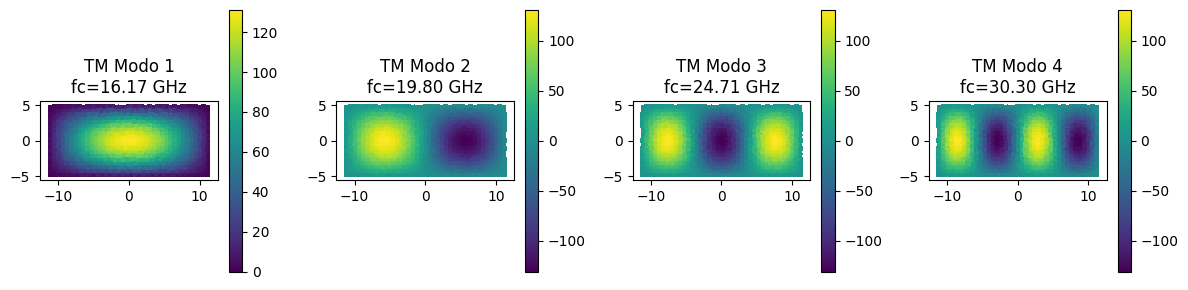

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import eigsh
from matplotlib.tri import Triangulation
import matplotlib.tri as mtri

# --------------------------
# 1. Parámetros físicos
# --------------------------
MODE = "TM"        # "TM" o "TE"
N_modes = 4
mm = 1e-3
a1 = 22.86 * mm    # WR-90: ancho
b1 = 10.16 * mm    # alto
eps0 = 8.8541878128e-12
mu0 = 4*np.pi*1e-7
eps_r = 1.0

# --------------------------
# 2. Generación de malla rectangular regular
# --------------------------
nx, ny = 40, 20   # número de nodos en cada dirección
x = np.linspace(-a1/2, a1/2, nx)
y = np.linspace(-b1/2, b1/2, ny)
X, Y = np.meshgrid(x, y)
points = np.vstack([X.ravel(), Y.ravel()]).T

# Triangulación (mallado con triángulos)
tri = Triangulation(points[:,0], points[:,1])

Nn = points.shape[0]   # nodos
Ne = tri.triangles.shape[0]   # elementos

# --------------------------
# 3. Inicialización matrices globales
# --------------------------
S = lil_matrix((Nn, Nn))
T = lil_matrix((Nn, Nn))

# --------------------------
# 4. Ensamblaje FEM
# --------------------------
for ie in range(Ne):
    nodes = tri.triangles[ie]
    xloc = points[nodes,0]
    yloc = points[nodes,1]

    # Área del triángulo
    De = np.linalg.det(np.array([[1, xloc[0], yloc[0]],
                                 [1, xloc[1], yloc[1]],
                                 [1, xloc[2], yloc[2]]]))
    Ae = abs(De)/2.0

    # Coeficientes b,c de las funciones de forma lineales
    b = np.zeros(3)
    c = np.zeros(3)
    for k in range(3):
        xk = np.roll(xloc, -k)
        yk = np.roll(yloc, -k)
        b[k] = (yk[1] - yk[2]) / De
        c[k] = (xk[2] - xk[1]) / De

    # Matriz de masa local
    Te = (Ae/12.0) * (np.ones((3,3)) + np.eye(3))

    # Matriz de rigidez local
    Se = Ae * (np.outer(b,b) + np.outer(c,c))

    # Ensamblaje
    for i in range(3):
        for j in range(3):
            S[nodes[i], nodes[j]] += Se[i,j]
            T[nodes[i], nodes[j]] += Te[i,j]

# --------------------------
# 5. Condiciones de frontera
# --------------------------
boundary_nodes = np.where(
    (np.isclose(points[:,0], -a1/2)) |
    (np.isclose(points[:,0],  a1/2)) |
    (np.isclose(points[:,1], -b1/2)) |
    (np.isclose(points[:,1],  b1/2))
)[0]

free_nodes = np.arange(Nn)

if MODE == "TM":
    # Dirichlet: eliminar nodos de frontera
    mask = np.ones(Nn, dtype=bool)
    mask[boundary_nodes] = False
    free_nodes = np.where(mask)[0]
elif MODE == "TE":
    # Neumann: no se eliminan nodos (condición natural)
    pass
else:
    raise ValueError("MODE debe ser 'TE' o 'TM'.")

Sff = S[free_nodes,:][:,free_nodes].tocsr()
Tff = T[free_nodes,:][:,free_nodes].tocsr()

# --------------------------
# 6. Resolver problema de autovalores
# --------------------------
vals, vecs = eigsh(Sff, k=N_modes, M=Tff, sigma=0.0, which='LM')
# lambda = kc^2
kc = np.sqrt(np.abs(vals))
fc = kc/(2*np.pi*np.sqrt(mu0*eps0*eps_r))

print("Frecuencias de corte [GHz]:")
for i,f in enumerate(fc):
    print(f"Modo {i+1}: {f*1e-9:.3f} GHz")

# --------------------------
# 7. Reconstruir y graficar modos
# --------------------------
fig, axs = plt.subplots(1, N_modes, figsize=(12,3))
for m in range(N_modes):
    field = np.zeros(Nn)
    field[free_nodes] = vecs[:,m]

    im = axs[m].tripcolor(points[:,0]/mm, points[:,1]/mm, tri.triangles,
                          field, shading='flat', cmap='viridis')
    axs[m].set_title(f"{MODE} Modo {m+1}\nfc={fc[m]*1e-9:.2f} GHz")
    axs[m].set_aspect('equal')
    fig.colorbar(im, ax=axs[m])
plt.tight_layout()
plt.show()
